# MK1 Propulsion Setup

Edgar Hernandez


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from propeller_analysis import PropellerAnalysis

def calculate_max_drag(plane, atmosphere, velocity, bank):
    """ temp solution to no object
     make sure bank is in rads """

    q = 0.5 * atmosphere['rho'] * velocity**2
    cl = plane['mtow'] * 9.81 / (q * plane['S'])
    cd = plane['cd_min'] + plane['cd_fus'] + plane['k'] *(1/np.cos(bank) * cl)**(2)
    drag = q * plane['S'] * cd
    return drag


# This is going to also serve as my basis for the next aircraft model I make
plane = {
    'cl_max': 1,  # kind of important
    'cl_a': 3.7,  # replace with a polar at some point
    'cl_0': 0.3252,    # polar can be form XFLR5 csv output and add fuselage drag
    'cd_min': 0.03, # with out fuselage
    'cd_fus': 0.005, # in reference to wing area (may not be a great estimate tbh but the estimate from Hoerner is much smaller)
    'k': 0.096527,  # 1
    'AR': 3.664,
    'S': 0.633984, # m^2
    'b': 1.524, # m
    'c': 0.416, # m
    'mtow': 4.0, # kg (a little over m3 gross mass)
    'm_empty': 2.453,
}
atmosphere = {
    'rho': 1.17864,  # kg/m^3
    'mu': 18*10**(-6),  # kg/m/s
}
max_bank=55  # degrees
max_airspeed=16.59*1.1  # m/s
max_drag= calculate_max_drag(
    plane, atmosphere, max_airspeed,bank=(max_bank*np.pi/180))
max_power_propulsive=max_drag*max_airspeed  # W
stall_speed=np.sqrt(2*plane['mtow']*9.81/(atmosphere['rho']*plane['S']*plane['cl_max']))


print(f'{max_drag}N of drag at {max_airspeed} m/s')

# Some other neat stuff
# print(stall_speed, 1.1*stall_speed, 1.2*stall_speed)



7.985793896744635N of drag at 18.249000000000002 m/s


Processing propeller files...:   0%|          | 0/56 [00:00<?, ?it/s]/opt/homebrew/Caskroom/miniconda/base/envs/dbf/lib/python3.13/site-packages/scipy/interpolate/_interpolate.py:497: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
Processing propeller files...: 100%|██████████| 56/56 [00:00<00:00, 113.61it/s]


Text(0, 0.5, 'Battery Current (A)')

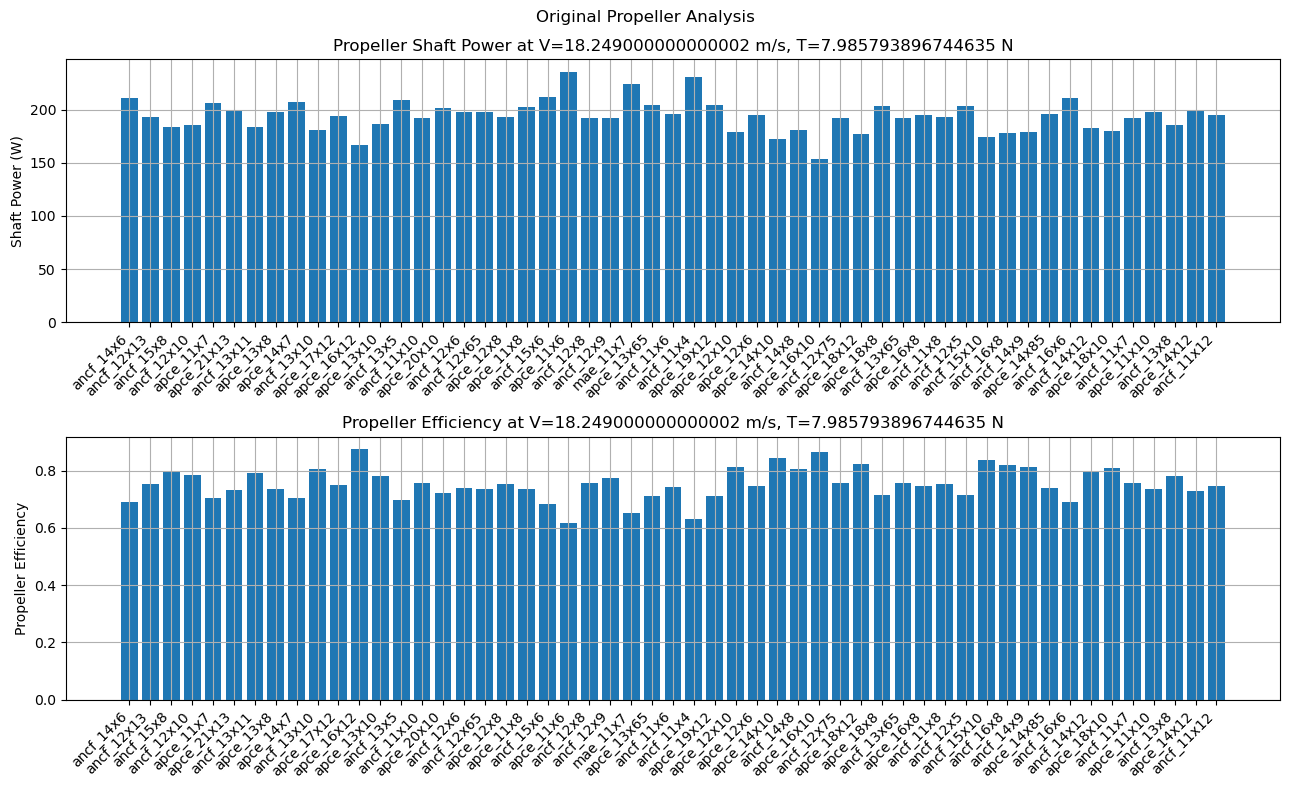

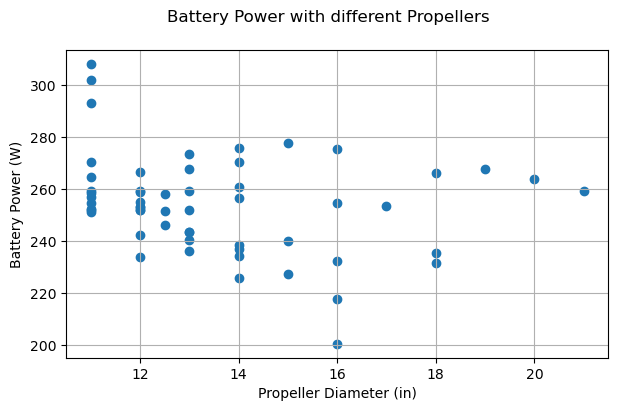

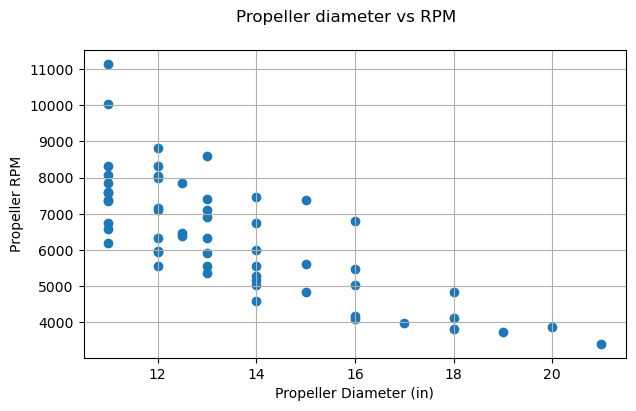

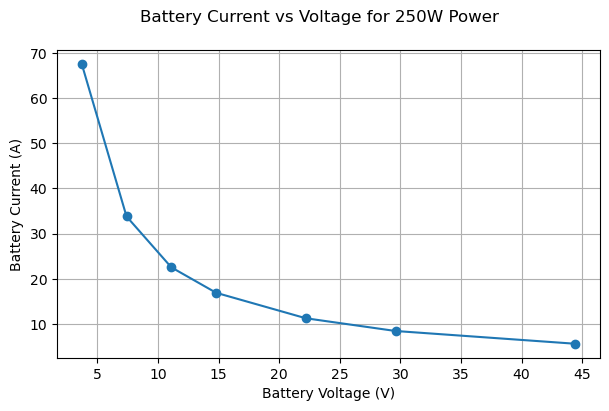

In [ ]:
# Propeller stuff now
yaml_dir = 'docs/props/new_yaml'
# banner data needed for analysis to work :(
banner_data= 'docs/isaac_banner_data_1.yaml'

labels=[]
diameters=[]
pitches=[]
thrusts=[]
shaft_powers=[]
batt_powers=[]
effs=[]
rpms=[]

# loop through all the prop files and see what the efficiencies are for 
# the props and get an idea of what kv motor we may need as well as just 
# see what size battery is best here
for file in tqdm(os.listdir(yaml_dir), desc='Processing propeller files...'):
    path = os.path.join(yaml_dir, file)
    prop = PropellerAnalysis(path,banner_path=banner_data)
    Fn, P, eff, omega = prop.analysis(max_airspeed, max_drag)
    if omega ==1 :
        # skip
        continue 
    batt_power= P/0.85/0.9
    # print(prop.label, float(prop.propeller.diameter)*39.37)
    labels.append(prop.label)
    diameters.append(prop.propeller.diameter)
    pitches.append(prop.propeller.pitch)
    thrusts.append(Fn)
    shaft_powers.append(P)
    batt_powers.append(batt_power)
    effs.append(eff)    # prop eff
    rpms.append(omega*60/2/np.pi)  # prop rpm

f1=plt.figure(figsize=(13,8))
f1.suptitle('Original Propeller Analysis')
a11 = f1.add_subplot(2,1,1)
a12 = f1.add_subplot(2,1,2)

a11.bar(labels, shaft_powers)
plt.setp(a11.get_xticklabels(), rotation=45, ha='right')
a11.set_ylabel('Shaft Power (W)')
a11.set_title(f'Propeller Shaft Power at V={max_airspeed} m/s, T={max_drag} N')

a12.bar(labels, effs)
plt.setp(a12.get_xticklabels(), rotation=45, ha='right')
a12.set_ylabel('Propeller Efficiency')
a12.set_title(f'Propeller Efficiency at V={max_airspeed} m/s, T={max_drag} N')

f1.tight_layout()

f2=plt.figure(figsize=(7,4))
f2.suptitle('Battery Power with different Propellers')
a21=f2.add_subplot(1,1,1)
a21.scatter(np.asarray(diameters)*39.37, batt_powers)
a21.set_xlabel('Propeller Diameter (in)')
a21.set_ylabel('Battery Power (W)')

f3=plt.figure(figsize=(7,4))
f3.suptitle('Propeller diameter vs RPM')
a31=f3.add_subplot(1,1,1)
a31.scatter(np.asarray(diameters)*39.37, rpms)
a31.set_xlabel('Propeller Diameter (in)')
a31.set_ylabel('Propeller RPM')

# Assume we need like 250W of power from the battery
power_max=250   # W
v_batt=np.array([1,2,3,4,6,8,12])*3.7  # V
amps=power_max/v_batt

f4=plt.figure(figsize=(7,4))
f4.suptitle(f'Battery Current vs Voltage for {power_max}W Power')
a41=f4.add_subplot(1,1,1)
a41.plot(v_batt, amps, marker='o')
a41.set_xlabel('Battery Voltage (V)')
a41.set_ylabel('Battery Current (A)')

# Try and get an idea for 

In [7]:
# Now lets see what motor kv we need
# kv=rpm/V
# V=3*3.7V
# rpm=5000rpm
kv=5000/(3*3.7)
print(f'For 5000rpm at 3S LiPo we need a motor kv of {kv} rpm/V')
# Ahr*V~Whr
cap=30/3/3.7
print(f'For 30Whr battery, the capacity should be around {cap} Ah')

For 5000rpm at 3S LiPo we need a motor kv of 450.4504504504504 rpm/V
For 30Whr battery, the capacity should be around 2.7027027027027026 Ah


## Overview

The setup would use a 3S LiPo w/ a motor of 450kv rated for continuous power greater than 250W. 

Propeller can either be an apce 16x12,10, 14x10 or an ancf 15x10

Or we can just use a propeller from the motor spec sheet that is rated for 3S battery

The battery should be 